In [1]:
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

In [2]:
def save_csv(objs : list, filename, fieldnames = None):
    if fieldnames is None:
        fieldnames = objs[0].keys()
    with open(filename, "w+") as out:
        writer = csv.DictWriter(out, fieldnames = fieldnames)
        writer.writeheader()
        for o in objs:
            writer.writerow(o)

In [3]:
def get_csv(filename : str):
    with open(filename, "r") as src:
        reader = csv.DictReader(src)
        return list(reader)

In [4]:
def city_state_str(event):
    return "{}, {}".format(event["city"].replace(" ", "").lower(), event["state"])

In [5]:
police_killings = get_csv("data/police-killings.csv")

In [6]:
for killing in police_killings:
    date_str = killing["incident_date"]
    parts = date_str.split("/")
    month = parts[0]
    day = parts[1]
    year = parts[2]
    killing["year"] = "20" + year
    killing["month"] = month
    killing["day"] = day

In [7]:
save_csv(police_killings, "data/police-killings.csv")

In [8]:
blm_protests = get_csv("data/blm-protests.csv")

In [9]:
for protest in blm_protests:
    date_str = protest["date"]
    parts = date_str.split("/")
    month = parts[0]
    day = parts[1]
    year = parts[2]
    protest["year"] = "20" + year
    protest["month"] = month
    protest["day"] = day

In [10]:
save_csv(blm_protests, "data/blm-protests.csv")

In [11]:
blm_cities = set([city_state_str(protest) for protest in blm_protests])

In [12]:
killings_cities = set([city_state_str(killing) for killing in police_killings])

In [13]:
city_killing_stats = {
    city : {
        "city" : city,
        "2013" : 0,
        "2014" : 0,
        "2015" : 0,
        "2016" : 0,
        "2017" : 0,
        "2018" : 0,
        "2019" : 0,
        "total" : 0
    } for city in killings_cities
}
for killing in police_killings:
    city = city_state_str(killing)
    city_killing_stats[city][killing["year"]] += 1
    city_killing_stats[city]["total"] += 1

In [14]:
black_city_killing_stats = {
    city : {
        "city" : city,
        "2013" : 0,
        "2014" : 0,
        "2015" : 0,
        "2016" : 0,
        "2017" : 0,
        "2018" : 0,
        "2019" : 0,
        "total" : 0
    } for city in killings_cities
}
for killing in police_killings:
    if killing["victim_race"] == "Black":
        city = city_state_str(killing)
        black_city_killing_stats[city][killing["year"]] += 1
        black_city_killing_stats[city]["total"] += 1

In [15]:
def new_city_dict(city):
    return {
        "city" : city,
        "2014" : 0,
        "2015" : 0,
        "total" : 0
    }

In [16]:
city_protest_counts = {
    city : new_city_dict(city)
    for city in blm_cities
}

for protest in blm_protests:
    city = city_state_str(protest)
    year = protest["year"]
    city_protest_counts[city][year] += 1
    city_protest_counts[city]["total"] += 1

In [17]:
def is_relevant(city_stat):
    years_with_killing = 0
    return city_stat["total"] >= 10

In [18]:
relevant_killing_city_counts = [city for city in city_killing_stats.values() if is_relevant(city)]
relevant_killing_cities = [city["city"] for city in relevant_killing_city_counts]
relevant_protest_city_counts = [new_city_dict(city) if city not in city_protest_counts else city_protest_counts[city] for city in relevant_killing_cities]

# Sanity checks
assert(len(relevant_protest_city_counts) == len(relevant_killing_city_counts))
for killing_count, protest_count in zip(relevant_killing_city_counts, relevant_protest_city_counts):
    assert(killing_count["city"] == protest_count["city"])

In [19]:
black_relevant_killing_city_counts = [city for city in black_city_killing_stats.values() if is_relevant(city)]
black_relevant_killing_cities = [city["city"] for city in black_relevant_killing_city_counts]
black_relevant_protest_city_counts = [new_city_dict(city) if city not in city_protest_counts \
                                      else city_protest_counts[city] for city in black_relevant_killing_cities]

# Sanity checks
assert(len(black_relevant_protest_city_counts) == len(black_relevant_killing_city_counts))
for killing_count, protest_count in zip(black_relevant_killing_city_counts, black_relevant_protest_city_counts):
    assert(killing_count["city"] == protest_count["city"])

In [20]:
def get_ys(city):
    before = (city["2013"] + city["2014"] + city["2015"])
    after = (city["2016"] + city["2017"] + city["2018"])
    if (before + after == 0):
        return 0
    return (after - before)

In [21]:
def get_normalized_ys(city):
    before = (city["2013"] + city["2014"] + city["2015"])
    after = (city["2016"] + city["2017"] + city["2018"])
    if (before + after == 0):
        return 0
    return (after - before) / (after + before)

In [22]:
xs = [city["total"] for city in relevant_protest_city_counts]
ys = [get_ys(city) for city in relevant_killing_city_counts]

In [23]:
reg = linregress(xs, ys)
reg

LinregressResult(slope=-0.2947869552172904, intercept=0.4407001296326698, rvalue=-0.3856872070402013, pvalue=0.00010415119107971853, stderr=0.072733834536164)

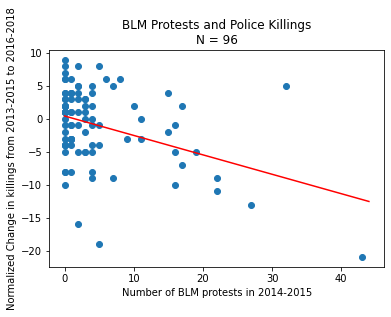

In [24]:
max_x = max(xs)
plt.scatter(xs, ys)
plt.plot([0, max_x + 1], [reg.intercept, reg.slope * (max_x + 1) + reg.intercept], "red")
plt.title("BLM Protests and Police Killings\nN = {}".format(len(xs)))
plt.ylabel("Normalized Change in killings from 2013-2015 to 2016-2018")
plt.xlabel("Number of BLM protests in 2014-2015")
plt.show()

In [25]:
unarmed_killings = [killing for killing in police_killings if killing["weapon"] == "unarmed"]

In [26]:
save_csv([
    {
        "city" : city,
        "protests" : city_protest_counts[city]["total"] if city in city_protest_counts else 0,
        "change" : get_ys(city_killing_stats[city])
    } for city in relevant_killing_cities
], "relevant_change.csv")

In [27]:
save_csv([
    {
        "city" : city,
        "protests" : city_protest_counts[city]["total"] if city in city_protest_counts else 0,
        "change" : get_normalized_ys(city_killing_stats[city])
    } for city in relevant_killing_cities
], "relevant_change_normalized.csv")

In [28]:
save_csv([
    {
        "city" : city,
        "protests" : city_protest_counts[city]["total"] if city in city_protest_counts else 0,
        "change" : get_ys(black_city_killing_stats[city])
    } for city in black_relevant_killing_cities
], "black_relevant_change.csv")

In [29]:
save_csv([
    {
        "city" : city,
        "protests" : city_protest_counts[city]["total"] if city in city_protest_counts else 0,
        "change" : get_normalized_ys(black_city_killing_stats[city])
    } for city in black_relevant_killing_cities
], "black_relevant_change_normalized.csv") 